Conventional wisdom has been that methods based on random search in the parameter space of policies are not very efficient for reinforcement learning problems.  

The methodology from ["Augmented Random Search"](https://arxiv.org/abs/1803.07055) opens the possibility to use simple functions (or policies) for continuous control problems. 

In this fork, several policies have been created as a starting point for interested developers or researchers. Moreover, given that DeepMind recently released thier control suite for continuous problems, a simple wrapper was also created to build policies on top of thier control suite.     

To follow along, you will first need to install ["Mujoco Pro v1.50"](https://www.roboti.us/index.html). Then make sure you install ["dm_control"](https://github.com/deepmind/dm_control).    

["Ray"](https://github.com/ray-project/ray) and ["Ray RLib"](http://ray.readthedocs.io/en/latest/rllib.html) are used to speed up the training process. 

Even though this fork has some MLP policies, all the policies have been implemented in Numpy. So a somewhat recent numpy version should work.

Finally, moviepy is used to render the agents. 

# Prelims

In [13]:
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib.animation as animation
import numpy as np
import time
from IPython.display import Image
from dm_control import suite
from basic_env import BasicEnv
from moviepy.editor import *
from moviepy.video.io.bindings import mplfig_to_npimage

# Background

The DeepMind Control Suite and Task provides a set of benchmarks for evaluating and comparing learning algorithms for continuous control problems. 


## DM Control Domain and Tasks 

### Walker Domain

A planar walker with three available tasks: stand, walk, and run. For the walk task, for example, the reward motivates an upright torso and forward velocity.  

In [2]:
env = suite.load('walker','walk', visualize_reward=True)

In [3]:
print('Action space:', env.action_spec())

Action space: BoundedArraySpec(shape=(6,), dtype=dtype('float64'), name=None, minimum=[-1. -1. -1. -1. -1. -1.], maximum=[1. 1. 1. 1. 1. 1.])


For the environment mentioned above, the action is a vector of (bounded) reals of size 6. Thus, any function could be use to represent the policy as long as the output of is consistent with the action space. 

In [4]:
time_step = env.reset()
print('Observation space:', time_step.observation)

Observation space: OrderedDict([('orientations', array([-0.40370384,  0.91488972,  0.91759742,  0.39751097,  0.20414347,
        0.97894098, -0.02272519,  0.99974175, -0.30266771,  0.95309614,
       -0.80039722, -0.59947001, -0.21454812, -0.97671342])), ('height', 1.3), ('velocity', array([0., 0., 0., 0., 0., 0., 0., 0., 0.]))])


time_step.observation provides the "observations" available to the learning agent. The dimension or shape of the observation is domain/task specific. For the walker-walk, for example, 24 elements are sent to the learning agent. 

#### Random play

As much as we would like to jump into complicated policies, sometimes it is a good idea to check the behavior of random agents. The code below uses a plain vanilla random policy that takes, believe or not, random actions. 

In [96]:
action_spec = env.action_spec()
time_step = env.reset()
returns = []
max_frame = 1000
frames = 0
width, height = 480, 480
video = []
for i in range(100):
    obs = env.reset()
    done = False
    totalr = 0.
    steps = 0
    while not done:
        action = np.random.uniform(action_spec.minimum,action_spec.maximum,size=action_spec.shape)
        time_step = env.step(action)
        if frames < max_frame:
            video.append(env.physics.render(height, width, camera_id=0))
        totalr += np.float32(time_step.reward)
        done = time_step.last()
        steps += 1
        frames += 1
    returns.append(totalr)

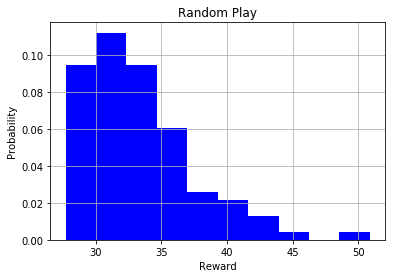

In [97]:
# the histogram of the rewards
n, bins, patches = plt.hist(returns,facecolor='blue',  normed=1)
plt.xlabel('Reward')
plt.ylabel('Probability')
plt.title('Random Play')
plt.grid(True)
plt.show()

The max reward per rollout is by design 1000, yet the random agent cannot obtain more than 50. This illustrate the complexity of the optimization problem. 

Given the "video" array created above, we can visualize the agent for several episodes. Below is an annimation of the random agent. 

In [98]:
from IPython.display import HTML

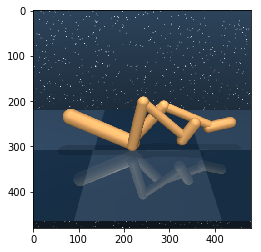

In [101]:
fig = plt.figure()
ims = []
for i in range(100):
    im = plt.imshow(video[i])
    ims.append([im])

anim = animation.ArtistAnimation(fig, ims, interval = 200, blit= True)
HTML(anim.to_html5_video())

Still interested? Have then a look at ARS.py, run_ars_policy.py, and policies.py. 

Several policies have been implemented, and many more are in my to-do list. As of today, the MLP policy with layer normalization is performing quite well in the walker-walk optimization problem, reaching levels of 700.  

In [104]:
HTML('<img src="img/mlp-walker-walk.gif">')